In [84]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier  #导入随机森林分类器
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold

In [85]:
# import data
filename= "data.csv"
raw = pd.read_csv(filename) # read_csv读取csv文件
print (raw.shape)
raw.head(10)

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8
8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,...,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9
9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10


In [86]:
# 5000 for test
kobe =  raw[pd.notnull(raw['shot_made_flag'])] # notnull()，返回值是布尔型的矩阵。再取raw[布尔型矩阵]返回的是'shot_made_flag'为非空的行
print (kobe.shape)

(25697, 25)


Text(0.5, 1.0, 'lat and lon')

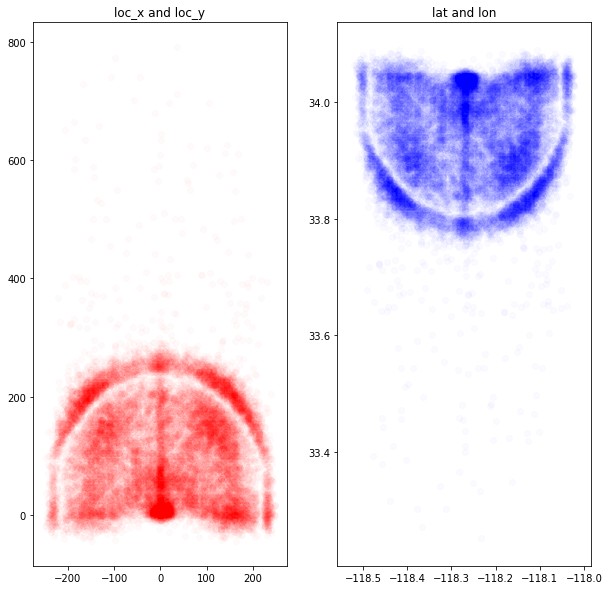

In [87]:
#plt.subplot(211) first is raw second Column
alpha = 0.02 # 这是设的透明度
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(kobe.loc_x, kobe.loc_y, color='R', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(kobe.lon, kobe.lat, color='B', alpha=alpha)
plt.title('lat and lon')

In [88]:
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)
#对于lat，loc_x，loc_y，lon这4个标签，我们取loc_x和loc_y这2个标签，并将其转化为极坐标的形式
#dist表示离篮筐的距离，angle表示投篮的角度，这样将会更好的科比投篮的反应结果``

loc_x_zero = raw['loc_x'] == 0
#print (loc_x_zero)
raw['angle'] = np.array([0]*len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi / 2 

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [89]:
# 这样我们可以保留其中的一个(这里我们保留了dist这个标签)，接着我们将minutes_remaining和seconds_remaining转化成一个标签remaining_time，
# 然后删除不必要的列，非数值型的转换成onehot编码格式
raw['remaining_time'] = raw['minutes_remaining'] * 60 + raw['seconds_remaining']

In [90]:
# unique 显示一列里所有不重复的值的集合
print(kobe.action_type.unique())
print(kobe.combined_shot_type.unique())
print(kobe.shot_type.unique())
print(kobe.shot_type.value_counts())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

In [91]:
kobe['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [92]:
#机器学习只能识别数值型的数据
#将赛季中'Jan-00' 'Feb-01' 'Mar-02'  ···  '1998-99'转换成
# 0  1  2  ··· 99
raw['season'] = raw['season'].apply(lambda x: int(x.split('-')[1]) )
raw['season'].unique()
# print(raw['season'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0], dtype=int64)

In [93]:
# kobe['team_id'].unique()
print(kobe['team_id'].unique())
print(kobe['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


In [94]:
pd.DataFrame({'matchup':kobe.matchup, 'opponent':kobe.opponent}) # DataFrame是一个【表格型】的数据结构
# 最常用的方法是传递一个字典来创建。DataFrame以字典的键作为每一【列】的名称，以字典的值（一个数组）作为每一列。DataFrame会自动加上每一行的索引

,matchup,opponent
1,LAL @ POR,POR
2,LAL @ POR,POR
3,LAL @ POR,POR
4,LAL @ POR,POR
5,LAL @ POR,POR
6,LAL @ POR,POR
8,LAL @ POR,POR
9,LAL @ POR,POR
10,LAL @ POR,POR
11,LAL vs. UTA,UTA


Text(0.5, 1.0, 'dist and shot_distance')

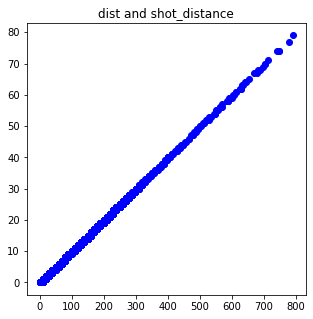

In [95]:
plt.figure(figsize=(5,5))

plt.scatter(raw.dist, raw.shot_distance, color='blue')
plt.title('dist and shot_distance')

In [96]:
# 查看科比的投篮区域次数
gs = kobe.groupby('shot_zone_area')
for g in gs:
    print(g[0])
print (kobe['shot_zone_area'].value_counts())
print (len(gs))

Back Court(BC)
Center(C)
Left Side Center(LC)
Left Side(L)
Right Side Center(RC)
Right Side(R)
Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64
6


Text(0.5, 1.0, 'shot_zone_range')

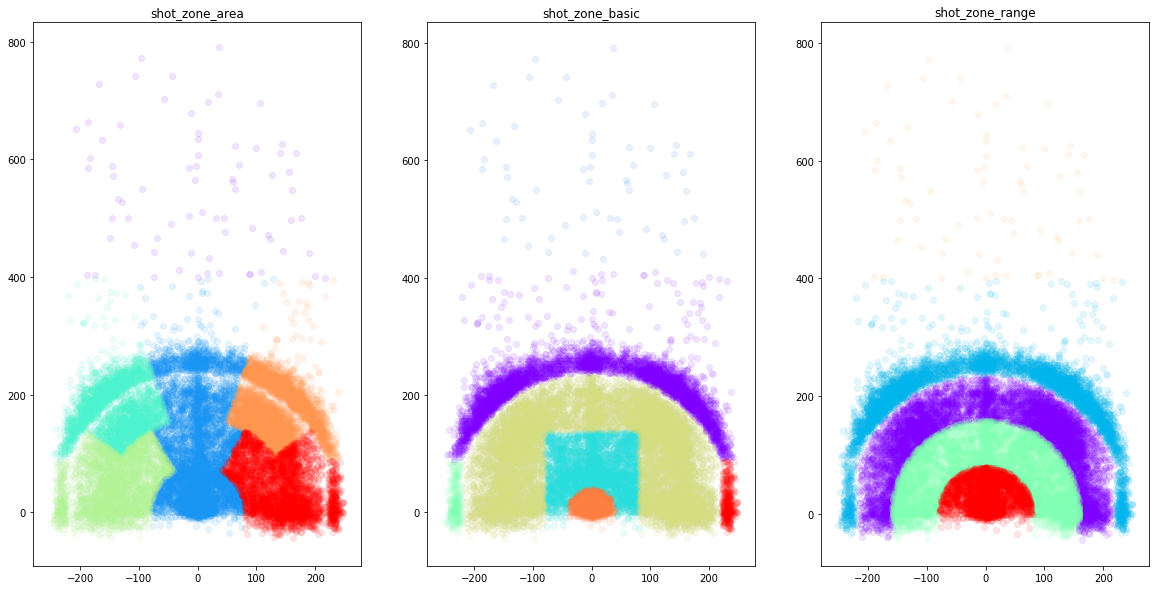

In [97]:
# 画图-对科比投篮的区域进行统计
import matplotlib.cm as cm  # colormap（色度图）
plt.figure(figsize=(20,10))  #指定画图域

def scatter_plot_by_category(feat):
    alpha = 0.1  #指定一个数字，用于后面的透明度
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))  
    # 在默认情况下，linspace函数可以生成元素为50的等间隔数列。而前两个参数分别是数列的开头与结尾，如果写入第三个参数，可以制定数列的元素个数
    # matplotlib.cm为内置的颜色地图, COLORMAP_RAINBOW为COLORMAP_*的数值
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)  # 画散点图

# shot_zone_area
plt.subplot(131)  #一行三列   第一个位置
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)  #一行三列   第二个位置
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)  #一行三列   第三个位置
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [98]:
# 删除对于比赛结果没有影响的数据
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']
for drop in drops:
    raw = raw.drop(drop, 1)
print(raw.shape)

(30697, 11)


In [99]:
print (raw['combined_shot_type'].value_counts())
pd.get_dummies(raw['combined_shot_type'], prefix='combined_shot_type')[0:6]

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64


,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,1,0,0,0,0
5,0,0,0,1,0,0


In [100]:
# 将非数值型的数据转换成为onehot编码的格式，加入到数据中并且将原来的数据删除
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)
print(raw.shape)
# 为什么会有130行之多，是因为我们用了onehot编码，具体什么是onehot编码这里就不做赘述了，感兴趣的可以谷歌或者百度一下。

# 最后我们总结一下，到底这25个标签还剩下什么，首先除去和比赛结果无关的标签，’shot_id’, ‘team_id’, ‘team_name’, ‘shot_zone_area’, ‘shot_zone_range’, ‘shot_zone_basic’,’matchup’, ‘lon’,
# ‘lat’, ‘seconds_remaining’, ‘minutes_remaining’，’shot_distance’, , ‘game_event_id’, ‘game_id’,
# ‘game_date’

# 然后’loc_x’, ‘loc_y’转换成了极坐标的形式，变成了’dist’,’angle’;’seconds_remaining’和’minutes_remaining’合并成了’remaining_time’。

# 最后将’action_type’, ‘combined_shot_type’, ‘shot_type’, ‘opponent’, ‘period’, ‘season’转换成onehot编码格式。

# 至此我们的数据处理工作基本完成了。


(30697, 130)


In [101]:
# 将数据分为训练集和测试集
train_kobe = raw[pd.notnull(raw['shot_made_flag'])]
# kobe =  raw[pd.notnull(raw['shot_made_flag'])] 
# notnull()，返回值是布尔型的矩阵。再取raw[布尔型矩阵]返回的是'shot_made_flag'为非空的行
print(train_kobe.shape)
print(len(train_kobe))
train_label = train_kobe['shot_made_flag']
print(train_label.shape)
train_kobe = train_kobe.drop('shot_made_flag', 1)
print(train_kobe.shape)
test_kobe = raw[pd.isnull(raw['shot_made_flag'])]
print(test_kobe.shape)
test_kobe = test_kobe.drop('shot_made_flag', 1)
print(test_kobe.shape)

(25697, 130)
25697
(25697,)
(25697, 129)
(5000, 130)
(5000, 129)


In [102]:
from sklearn.ensemble import RandomForestRegressor  # 随机森林是一种ensemble算法
from sklearn.metrics import confusion_matrix,log_loss
import time

In [105]:
## 具体的思路是利用随机森林分类器配合着交叉验证的方法进行数据的分析，先找到最佳的树的个数，和树的深度。
# find the best n_estimators for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')  # 随机森林分类器
min_score = 100000  # 使之等于最小log_loss损失值的那组模型
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)  # [  1  10 100] # 开始不知道多少棵树合适，所以先选一个大致范围，经过算法来选一个最合适的数
# 用随机森林训练模型，为了方便，森林的宽度和深度用了3个值（1,10,100）
# logspac用于创建等比数列，开始点和结束点是10的幂，可以改变base参数来改变基数
for n in range_n:  # n就是指要构造多少棵树来组成随机森林
    print("the number of trees : {0}".format(n))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)  # 就是构造了一个随机森林的模型  # 随机森林分类器建立一个模型
    # n_estimators,决策树的个数，越多越好，但是性能就会越差，至少100左右（具体数字忘记从哪里来的了）可以达到可接受的性能和误差率。 
    # for train_k, test_k in KFold(len(train_kobe), n_folds=10, shuffle=True):  
    kf = KFold(n_splits=10, shuffle=True)
    for train_k, test_k in kf.split(train_kobe):
        # K折交叉验证：sklearn.model_selection.KFold(n_splits=3, shuffle=False, random_state=None)
#         参数(n, n_folds=3, shuffle=False, random_state=None)
#         n为总数
#         n_folds为分为多少个交叉验证集
#         shuffle为是否随机
#         random_state设置随机因子
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])  # 一部分为数据，一部分为标签
        # fit(X, y, sample_weight=None) 从训练数据集(X,y)上建立一个决策树森林 
        # X : array-like or sparse matrix of shape = [n_samples, n_features]   y,目标值（分类中的类标签，回归中的实数）
        # 样本权值。 如果没有，那么样本的权重是相等的。 当搜索每个节点中的分割时，将会忽略创建具有净零或负权重的子节点的分割。 
        # 在分类的情况下，分裂也会被忽略，如果它们会导致任何一个类别在任何一个孩子节点中都带有负权重。
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])  # 对模型进行预测  
        # predict_proba(x)：给出带有概率值的结果。每个点在所有label的概率和为1. 
        # predict(x)：直接给出预测结果。内部还是调用的predict_proba()，根据概率的结果看哪个类型的预测值最高就是哪个类型
        # min_samples_split:根据属性划分节点时，每个划分最少的样本数
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10  #对模型进行评估
        # y表示样本的真实标签(1或-1)，pp表示模型预测为正样本的概率
#         def logloss(true_label, predicted_prob):
#             if true_label == 1:
#                 return -log(predicted_prob)
#             else:
#                 return -log(1 - predicted_prob)
        # 所以只要loglss是在0.693以上，就说明模型是失败的
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')  # 随机森林分类器
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:  # m指要给树指定一个树的最大的深度，防止过拟合。深度太深，容易分的太细
    print("the max depth : {0}".format(m))
    t1 = time.time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)  
    # max_depth : integer or None, optional (default=None)  整数或者无值，可选的（默认为None）
    # （决策）树的最大深度。如果值为None，那么会扩展节点，直到所有的叶子是纯净的，或者直到所有叶子包含少于min_sample_split的样本。
    # for train_k, test_k in KFold(len(train_kobe), n_folds=10, shuffle=True):
    kf = KFold(n_splits=10, shuffle=True)
    for train_k, test_k in kf.split(train_kobe):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (2.500sec)
the number of trees : 10
Done processing 10 trees (11.970sec)
the number of trees : 100
Done processing 100 trees (114.852sec)
100 11.844088873818356
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (9.813sec)
the max depth : 10
Done processing 10 trees (39.273sec)
the max depth : 100
Done processing 100 trees (134.208sec)
10 10.997306155280727


Text(0.5, 0, 'max depth')

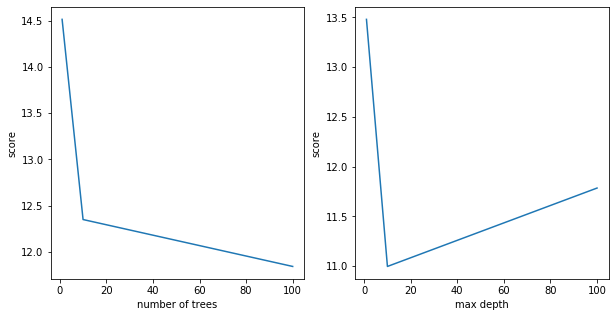

In [106]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

In [ ]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train_kobe, train_label)
# 474241623